# Capstone: Profile Based Job Matching Recommendation System

## Problem Statement

With regards to the hurdles recruiters face which born inefficiency to a hiring process, this project aims to build a recommendation system using natural language processing techniques to match skillsets between the job requirements and resumes then return the top recommended candidates.

### Overall Contents:

- [Background](#1.-Background) **(In this notebook)**
- [Data cleaning](#2.-Data-cleaning) **(In this notebook)**
- Exploratory Data Analysis
- Word Vectorization using CountVectorizer
- Word Vectorization using TFIDF-Vectorizer
- Final Recommender Model
- Cost Benefit Analysis
- Conclusion

## 1. Background 

There are 6 steps to a recruitment process that may vary company to company depending on the business infrastructure. These 6 steps are preparing, sourcing, screening, selecting, hiring and onboarding.

A recruitment process takes anywhere from a few days to four months, according to LinkedIn's 2017 global survey. On average, each corporate job offer attracts 250 resumes and it takes approximately 6 seconds for a recruiter to scan a resume finding relevant qualities related to the job. Out of the 250 resumes, the typical employer will then interview 4–6 candidates for the job, and only one will be successful.[[1]](https://zety.com/blog/hr-statistics)

According to recruiters from 2017 Recruiter Sentiment Study MRI Network, 63% mentioned that there aren't enough suitable candidates , 34% had difficulty finding passive talent and 23% found too many unqualified junk resumes from job boards.[[2]](https://mrinetwork.com/media/304094/2017hiringsentimentstudy.pdf) These are just some of the barriers faced to identify quality talent. 


### 1.1 Datasets

There are 3 datasets used for this project, 1 for job posting and 2 for resumes. The data source are obtained from kaggle.

The datasets are:
- job_post: A [Kaggle](#https://www.kaggle.com/elroyggj/indeed-dataset-data-scientistanalystengineer) dataset which comprises of Data Scientist/Analyst/Enginner job posting from Indeed.com in CSV format
- resume_1: A [Kaggle](#https://www.kaggle.com/gauravduttakiit/resume-dataset) dataset which comprises of resumes with job title and the resume details in CSV format.
- resume_2: A [Kaggle](#https://www.kaggle.com/akmalfaisal/resumeinfo) dataset which comprises of LinkedIn profile in CSV format.  

## 2. Data cleaning

### 2.1 Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
pd.set_option('display.max_colwidth', None)
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

### 2.2 Created a function to provide information on dataset

In [2]:
def basic_info(df):
    ''' 
    Input Dataframe
    Output Name of Column & its Data Type, Number of Rows/Columns, Number of Null/Duplicate Rows
    '''
    print("========== Summary ==========")
    print(df.info())
    
    print("\n=========== Shape ===========")
    print(f"(row, column) = {df.shape}") # prints the shape of the dataset
    
    print("\n====== Total Null/Dup =======")
    null_row = df.isnull().sum().sum()
    print(f"Total Null Rows: {null_row} ({round(null_row*100/len(df),2)}%)")
    dup_row = df[df.duplicated(keep=False)].shape[0]
    print(f"Total Duplicate Rows: {dup_row} ({round(dup_row*100/len(df),2)}%)")
     
    if null_row > 0:
        print("\n========= Null Rows =========")
        print(df.isnull().sum())
        
        sns.set(); #setting seaborn as default background
        msno.bar(df)
        plt.title("Missing value count for dataset",fontsize = 30)
    

### 2.3 Importing job posting dataset

In [3]:
# Importing dataset of job posting
job_df = pd.read_csv("../datasets/job_posting.csv")

In [4]:
# Subset of how the dataframe looks like
job_df.head()

,Unnamed: 0,Job_Title,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,Company,No_of_Reviews,No_of_Stars,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
0,0,Data Scientist,https://www.indeed.com/rc/clk?jk=6a105f495c36afe3&fccid=281a27deb89bbe92&vjs=3,<80000,data_scientist,"['SAP', 'SQL']",2,Express Scripts,3301.0,3.3,...,0,0,0,1,0,0,0,1,0,0
1,1,Data Scientist,https://www.indeed.com/rc/clk?jk=86afd561ea8c60bc&fccid=b584cf601069b5d0&vjs=3,<80000,data_scientist,"['Machine Learning', 'R', 'SAS', 'SQL', 'Python']",5,Money Mart Financial Services,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,Data Scientist,https://www.indeed.com/rc/clk?jk=e0aad317e6d45d9b&fccid=b39fb6f124ce8586&vjs=3,<80000,data_scientist,"['Data Mining', 'Data Management', 'R', 'SAS', 'SQL', 'STATA', 'SPSS', 'Data Analysis', 'Python']",9,comScore,62.0,3.5,...,0,0,0,1,0,0,0,0,0,0
3,3,Graduate Studies Program - Data Scientist,https://www.indeed.com/rc/clk?jk=1cfdd9e391a6328a&fccid=e9870e3159e9c6ac&vjs=3,<80000,data_scientist,['Certified Internal Auditor'],1,Central Intelligence Agency,158.0,4.3,...,0,1,0,0,0,0,0,0,0,1
4,4,Data Scientist I,https://www.indeed.com/rc/clk?jk=fec647775a21ecc6&fccid=2c6850e24c8a2811&vjs=3,<80000,data_scientist,"['Statistical Software', 'Time Management', 'R', 'Microsoft Office', 'Excel', 'Tableau', 'Data Science']",7,Federal Reserve Bank of Dallas,495.0,4.1,...,0,0,0,0,0,0,1,0,0,0


========== Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        5715 non-null   int64  
 1   Job_Title                         5715 non-null   object 
 2   Link                              5715 non-null   object 
 3   Queried_Salary                    5715 non-null   object 
 4   Job_Type                          5715 non-null   object 
 5   Skill                             5483 non-null   object 
 6   No_of_Skills                      5715 non-null   int64  
 7   Company                           5611 non-null   object 
 8   No_of_Reviews                     4753 non-null   float64
 9   No_of_Stars                       4753 non-null   float64
 10  Date_Since_Posted                 5611 non-null   float64
 11  Description                       5413 

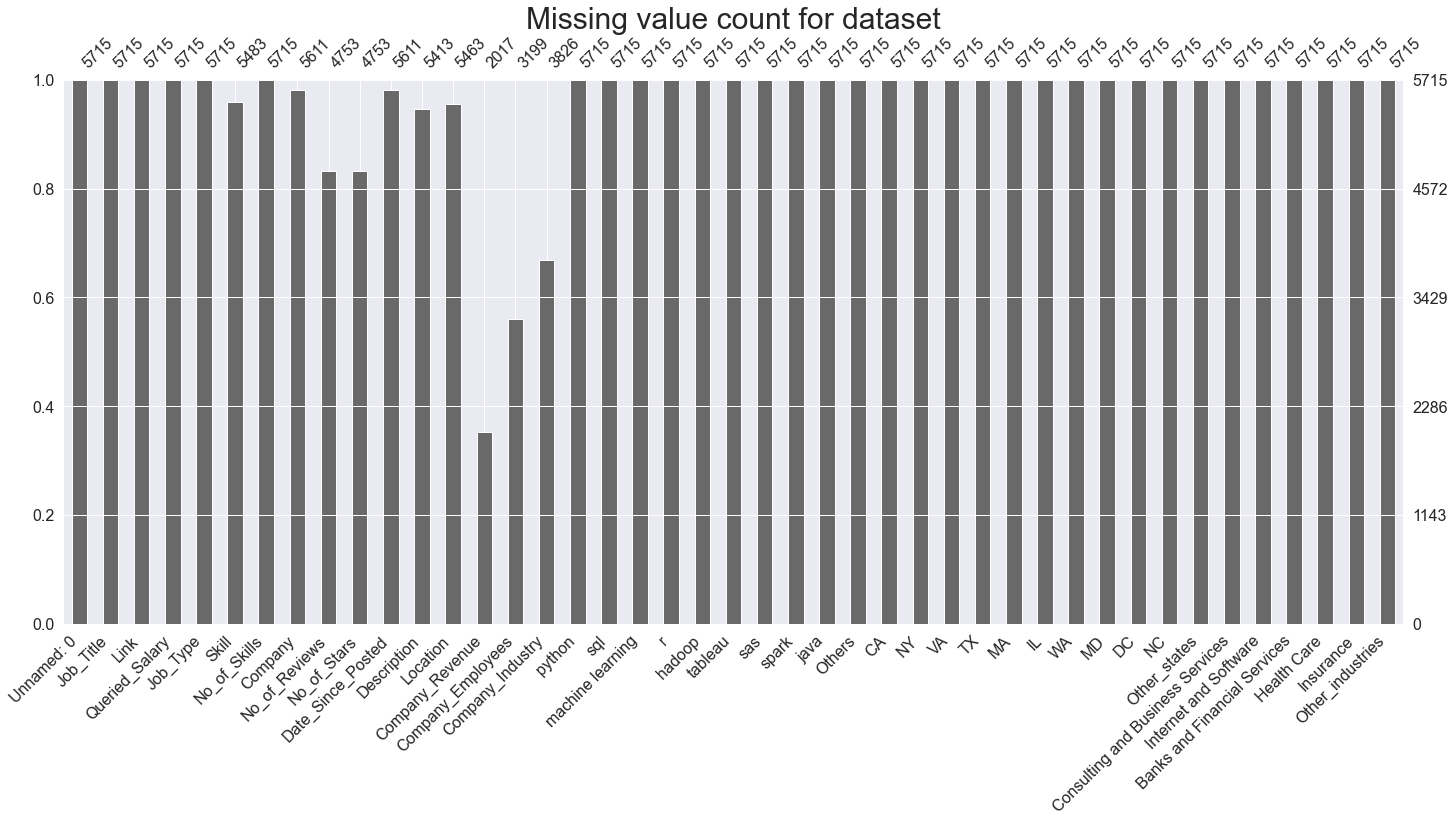

In [5]:
# applying the function onto the job posting dataset
basic_info(job_df)

###### Comments:

There are no duplicated entries however there are several null values in some of the columns. Let us further investigate at each of the columns with null.

### 2.3.1 Initial EDA

#### 2.3.1.1 Investigating Null values

#### Column: Skill

In [6]:
# Filtering entries with missing skill input
job_df.loc[job_df['Company'].isnull()].head()

,Unnamed: 0,Job_Title,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,Company,No_of_Reviews,No_of_Stars,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
401,401,Data Scientist,https://www.indeed.com/company/HNI-Corporation/jobs/Data-Scientist-dd9568cc8da2c44f?fccid=281cabfb632997df&vjs=3,100000-119999,data_scientist,"['Statistical Software', 'Machine Learning', 'R', 'SAS', 'Python']",5,NaN,72.0,3.6,...,0,0,0,1,0,0,0,0,0,0
409,409,Data Scientist,https://www.indeed.com/company/HNI-Corporation/jobs/Data-Scientist-24f40cd56051b5ed?fccid=281cabfb632997df&vjs=3,100000-119999,data_scientist,"['Statistical Software', 'Machine Learning', 'R', 'SAS', 'Python']",5,NaN,72.0,3.6,...,0,0,0,0,0,0,0,0,0,0
432,432,Data Scientist,https://www.indeed.com/rc/clk?jk=d4ef84b6925d76fd&fccid=7c60e205aab51bb4&vjs=3,100000-119999,data_scientist,NaN,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
549,549,Data Scientist (944),https://www.indeed.com/company/ABC-Supply-Co.-Inc/jobs/Data-Scientist-49adcb479d6a010a?fccid=042d4158e141fbb6&vjs=3,100000-119999,data_scientist,"['Machine Learning', 'Power BI', 'Azure', 'R', 'Python', 'SQL', 'Tableau']",7,NaN,456.0,3.7,...,0,0,0,0,0,0,0,0,0,0
1166,1166,Data Scientist,https://www.indeed.com/rc/clk?jk=fa523723e455fc78&fccid=5be173f0f2dd3843&vjs=3,120000-139999,data_scientist,NaN,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# List of companies with missing entries in skill 
job_df.loc[job_df['Skill'].isnull()]['Company'].unique()

array(['Google', 'UES', 'Elder Research Inc',
       'University of California San Francisco',
       'Universal Consulting Services', 'UCS Consulting', 'Comrise',
       'Deloitte', 'The Hanover Insurance Group',
       'Prime Solutions Group (PSG)', "Gayathri's Sandbox",
       'ISE Data Systems', 'eQHealth Solutions', 'US Pharmacopeia',
       'McKinsey & Company', nan, 'Delaware North', 'Conagra Brands',
       'BLUEHAWK, LLC', 'TopSchoolJobs.org', 'Humana', 'Allstate',
       'Facebook', 'Genedata', 'NEURA', 'Vantiv', 'Intuit', 'Genentech',
       'Integral Consulting Services, Inc.', 'Gartner, Inc.', 'Tesla',
       'EMIDS', 'Roche', 'Kaiser Permanente', 'Bryant & Stratton College',
       'JLL', 'Ace Technologies', 'AVID CENTER STAFF', 'XLA',
       'Internet Brands', 'Blade', 'National Grid', 'Resolvit, LLC',
       'Advance Auto Parts', 'London Stock Exchange Group', 'CDW',
       'Graphic Products', 'Johns Hopkins University',
       'Office of the Nassau County Comptroller',

In [8]:
# total number of companies with missing entries in skill 
job_df.loc[job_df['Skill'].isnull()]['Company'].nunique()

154

In [9]:
# List of industries with missing entries in skill 
job_df.loc[job_df['Skill'].isnull()]['Company_Industry'].unique()

array(['Internet and Software', nan, 'Education and Schools',
       'Consulting and Business Services', 'Insurance',
       'Consumer Goods and Services', 'Health Care',
       'Banks and Financial Services', 'Pharmaceuticals', 'Government',
       'Media, News and Publishing', 'Industrial Manufacturing',
       'Real Estate', 'Auto', 'Organization', 'Construction', 'Retail',
       'InsuranceHealth Care', 'Aerospace and Defense',
       'Telecommunications'], dtype=object)

###### Comments:
There are a total of 154 companies with an absence of skills mentioned in the posting, they are also very well diversed in terms of the industries.

#### Column: Company

In [10]:
# Filtering entries with missing company input
job_df.loc[job_df['Company'].isnull()]

,Unnamed: 0,Job_Title,Link,Queried_Salary,Job_Type,Skill,No_of_Skills,Company,No_of_Reviews,No_of_Stars,...,MD,DC,NC,Other_states,Consulting and Business Services,Internet and Software,Banks and Financial Services,Health Care,Insurance,Other_industries
401,401,Data Scientist,https://www.indeed.com/company/HNI-Corporation/jobs/Data-Scientist-dd9568cc8da2c44f?fccid=281cabfb632997df&vjs=3,100000-119999,data_scientist,"['Statistical Software', 'Machine Learning', 'R', 'SAS', 'Python']",5,NaN,72.0,3.6,...,0,0,0,1,0,0,0,0,0,0
409,409,Data Scientist,https://www.indeed.com/company/HNI-Corporation/jobs/Data-Scientist-24f40cd56051b5ed?fccid=281cabfb632997df&vjs=3,100000-119999,data_scientist,"['Statistical Software', 'Machine Learning', 'R', 'SAS', 'Python']",5,NaN,72.0,3.6,...,0,0,0,0,0,0,0,0,0,0
432,432,Data Scientist,https://www.indeed.com/rc/clk?jk=d4ef84b6925d76fd&fccid=7c60e205aab51bb4&vjs=3,100000-119999,data_scientist,NaN,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
549,549,Data Scientist (944),https://www.indeed.com/company/ABC-Supply-Co.-Inc/jobs/Data-Scientist-49adcb479d6a010a?fccid=042d4158e141fbb6&vjs=3,100000-119999,data_scientist,"['Machine Learning', 'Power BI', 'Azure', 'R', 'Python', 'SQL', 'Tableau']",7,NaN,456.0,3.7,...,0,0,0,0,0,0,0,0,0,0
1166,1166,Data Scientist,https://www.indeed.com/rc/clk?jk=fa523723e455fc78&fccid=5be173f0f2dd3843&vjs=3,120000-139999,data_scientist,NaN,0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574,5574,Team Lead – Big Data Engineer,https://www.indeed.com/company/DDB-Mudra-Group/jobs/Team-Lead-Big-Data-Engineer-43efe257d1c08df1?fccid=7c144c2412d39880&vjs=3,140000-159999,data_engineer,"['Pig', 'JavaScript', 'Hive', 'XML', 'Hadoop', 'Scripting', 'SDLC', 'Scala', 'Kafka', 'Perl', 'HBase', 'JSON', 'Java', 'REST', 'Shell Scripting', 'Python']",16,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5613,5613,Azure Big Data Engineer,https://www.indeed.com/company/Accenture/jobs/Azure-Big-Data-Engineer-a0f24ca4104a1a5d?fccid=a4e4e2eaf26690c9&vjs=3,>160000,data_engineer,"['Spark', 'Design Experience', 'Hadoop', 'NoSQL', 'Azure', 'Scala', 'Python', 'SQL']",8,NaN,14988.0,4.0,...,0,0,0,0,0,0,0,0,0,0
5615,5615,AWS Big Data Engineer,https://www.indeed.com/company/Accenture/jobs/Aws-Big-Data-Engineer-3409625483b1d406?fccid=a4e4e2eaf26690c9&vjs=3,>160000,data_engineer,"['Hadoop', 'DynamoDB', 'Scala', 'Java', 'Spark', 'Design Experience', 'Informatica', 'NoSQL', 'Python', 'AWS']",10,NaN,14988.0,4.0,...,0,0,0,0,0,0,0,0,0,0
5618,5618,Data Engineer,https://www.indeed.com/company/Wag!/jobs/Data-Engineer-0633d6309b9f2be8?fccid=381733c3e1596619&vjs=3,>160000,data_engineer,"['Hadoop', 'Kafka', 'Ansible', 'Tableau', 'Big Data', 'MySQL', 'S3', 'Spark', 'Kubernetes', 'Docker', 'Python', 'AWS']",12,NaN,285.0,3.7,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Checking if there are any duplicates entries using the link
job_df.loc[job_df['Company'].isnull()]['Link'].nunique()

104

###### Comments:
There are a total of 104 entries with missing company name, however we can still use them as valid entries as there isn't any duplicates in terms of the link provided

#### Column: No_of_Reviews & No_of_Stars

In [12]:
# Filtering entries with missing Reviews count input
job_df.loc[job_df['No_of_Reviews'].isnull()]['No_of_Stars'].isnull().value_counts()

True    962
Name: No_of_Stars, dtype: int64

###### Comments: 

There are a total number of 962 entries with missing review and stars awarded. We can assume that if an entry is missing the review, the stars awarded is missing as well. 

#### Column: Date_Since_Posted

In [13]:
# List of companies with missing entries in dates 
job_df.loc[job_df['Date_Since_Posted'].isnull()]['Company'].unique()

array([nan], dtype=object)

###### Comments:
Entries without a date also seem to have left out the company name and may also be a data entry mistake.

#### Column: Description

In [14]:
# List of companies and number of skills mentioned without a description. 
job_df.loc[job_df['Description'].isnull()][['Company','No_of_Skills']].sort_values(by=['Company','No_of_Skills'],ascending=False).head(40)

,Company,No_of_Skills
4511,ktMINE,3
184,eBay Inc.,13
634,eBay Inc.,4
428,devwrx,5
4067,ddms,14
3508,ddms,11
4364,cableyou,0
1045,b.well,6
2483,aThingz,17
3054,"Zumba Fitness, LLC",4


###### Comments:
There are several companies with multiple entries not displaying job description. We can observe that some of the companies have 0 skills mentioned as well.

#### Column: Location

In [15]:
# Unique Locations in the dataset
job_df.Location.unique()

array(['MO', 'TX', 'OR', 'DC', 'MD', 'NY', 'GA', 'ID', 'PA', 'FL', 'MA',
       'VA', 'NJ', 'LA', 'CA', 'MN', 'WA', 'NC', 'IL', 'CO', 'UT', 'OH',
       'USA', 'AR', 'ME', 'NV', 'CT', 'REMOTE', 'RI', 'TN', 'WI', 'SC',
       'MI', 'KY', 'AZ', 'NE', 'IN', 'NM', 'AL', 'KS', 'IA', 'DE', nan,
       'HI', 'NH', 'OK', 'VT', 'WV', 'SD', 'WY', 'MT', 'ND'], dtype=object)

In [16]:
# Filtering companies with missing location in the entries
job_df.loc[job_df['Location'].isnull()]['Company'].unique()

array([nan, 'Elite SEM', 'All-In Analytics', 'InVision Studio',
       'cableyou', 'Availity, LLC.', 'BlueLabs Analytics',
       'Colorado Community Managed Care Network', 'Koddi', 'A Could Guru',
       'Quest Analytics', 'GlassDoor', 'Technamo LLC', '2DA Analytics',
       'MarketDial', 'Recorded Future', 'Arkatechture', 'Bertelsmann',
       'Aunalytics', 'Nielsen', 'Advanced Technology Group Inc',
       'Code Pilot', 'UpClear', 'Acustream',
       'East Daley Capital Advisors', 'Denodo Technologies', 'AQR',
       'Denodo', 'eHire, LLC', 'Auth0',
       'Blue Cross Blue Shield of Arizona', 'Hook & Loop Creative',
       'ktMINE', 'SharpSpring', 'Pairwise',
       'Accion in Arizona, Colorado, Nevada, New Mexico and Texas',
       'Real Capital Analytics (RCA)', 'Qwinix', 'Intrexon Corporation.',
       'Intalere Inc', 'MOBE, LLC', 'Asics Digital', 'Lirio',
       'VVC Holding Corp', 'Viral Launch, Inc.', 'Farmers Fridge',
       'United States Associati', 'REsurety', 'The Cadmus 

###### Comments:

We can recognize that the missing inputs could be human error in data entry or maybe the company had a posting with the intention that the job may require travelling and thus did not input any definite location.  

#### Column: Company Revenue & Company Employees

In [17]:
job_df.loc[job_df['Company_Revenue'].isnull()]['Company'].head()

1     Money Mart Financial Services
2                          comScore
3       Central Intelligence Agency
4    Federal Reserve Bank of Dallas
5          National Security Agency
Name: Company, dtype: object

In [18]:
job_df.loc[job_df['Company_Employees'].isnull()]['Company'].head()

1    Money Mart Financial Services
2                         comScore
3      Central Intelligence Agency
5         National Security Agency
6                      NYC Careers
Name: Company, dtype: object

###### Comments:

Some of the companies are related to the government sectors such as Central Intelligence Agency, National Security Agency and thus may be more confidential in their company details.

#### Column: Company Industry

In [19]:
job_df.loc[job_df['Company_Industry'].isnull()]['Company'].head(10)

1     Money Mart Financial Services
2                          comScore
5          National Security Agency
7                       OM Partners
13             Elev8 Hire Solutions
16       Achievement Network (ANet)
31               Intuitive Surgical
42                          iD Tech
44                Canvas Technology
47                           OpenAI
Name: Company, dtype: object

###### Comments:

Companies without a industry mentioned could be due to a human error in data entry or perhaps there is no specific industry and thus it was being left out.

#### 2.3.1.2 EDA on No. of skills

In [20]:
# Checking the range of number of skills required.
job_df['No_of_Skills'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)

In [21]:
# Displaying the skillset distribution 
job_df['No_of_Skills'].sort_values().describe()

count    5715.000000
mean        7.803675
std         5.091596
min         0.000000
25%         4.000000
50%         7.000000
75%        11.000000
max        20.000000
Name: No_of_Skills, dtype: float64

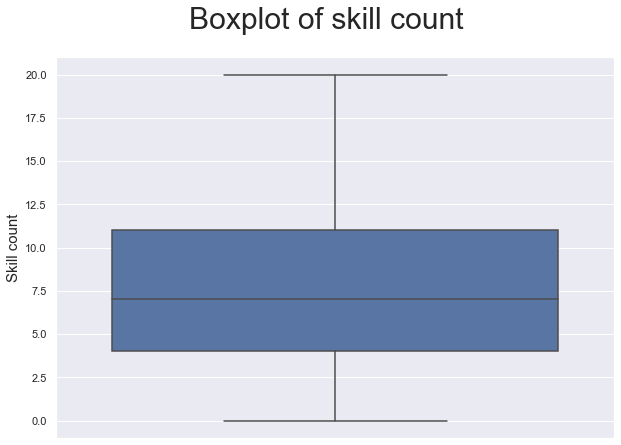

In [22]:
# Creating a boxplot to visualize the distribution of skillset
boxplt, ax = plt.subplots(figsize = (10,7))
ax = sns.boxplot(y = 'No_of_Skills', data= job_df)
plt.ylabel("Skill count",size = 15)
plt.suptitle("Boxplot of skill count",size=30);

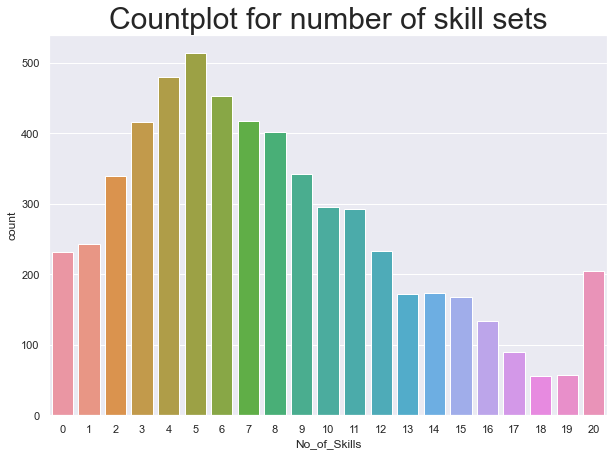

In [23]:
# Creating a countplot to visualize the number of skills sets
countplt, ax = plt.subplots(figsize = (10,7))
plt.title('Countplot for number of skill sets',size = 30)
ax =sns.countplot(x='No_of_Skills', data = job_df);
# plt.savefig("../images/no_of_skill_sets.png",bbox_inches='tight')

##### Comments:
The number of skill required ranges from 0 to 20. We will have to further explore what do 0 skills requirement meant. <br>
Each posting have an average of 7 posts, we can consider using the mean as the benchmark of number of skills required for the recommendation system. 

In [24]:
# Printing out the following regarding absence of skillset:
# Total count of companies:
# Top 15 companies with industry and count of posting in the dataset. 
print(f"Total Number of companies that do not mention skillset requirements: {job_df.loc[job_df['No_of_Skills'] ==0][['Company']].nunique()[0]}")
print(" ")
print("="*70)
print(f"Total 15 company with posting that does not require skillset:\n\n{job_df.loc[job_df['No_of_Skills'] ==0][['Company','Company_Industry']].value_counts().sort_values(ascending=False).head(15)}")
print("="*70)
print(" ")

Total Number of companies that do not mention skillset requirements: 154
 
Total 15 company with posting that does not require skillset:

Company                                 Company_Industry                
Kaiser Permanente                       Health Care                         12
Facebook                                Internet and Software                6
Capgemini                               Consulting and Business Services     6
University of California San Francisco  Education and Schools                5
Tesla                                   Industrial Manufacturing             5
The Hanover Insurance Group             Insurance                            5
JLL                                     Real Estate                          4
Ace Technologies                        Internet and Software                4
Google                                  Internet and Software                4
Genentech                               Pharmaceuticals                      4

##### Google's job description in the posting.

In [25]:
# Filtering out Google's job description
job_df.loc[job_df['Company']=='Google'][['Description']].head(3)

Description
27  [<ul><li>\r\r\nWe are accepting applications until January 28, 2019.</li><li>\r\r\nOur team will review applications on a rolling basis and interviews will begin in November 2018. It is in your best interest to submit your application early.</li><li>\r\r\nThe Google AI Residency Program will have 3 start dates over the course of 5 months, from June to October 2019. Exact dates are yet to be determined.</li></ul>, <p><b>\r\r\nAbout the Program:</b><br/>\r\r\nThe Google AI Residency Program is a 12-month role designed to advance your career in machine learning research. The goal of the residency is to help residents become productive and successful AI researchers.</p>, <p>As part of this program, Residents collaborate with distinguished scientists from various Google AI teams working on machine learning applications and problems. Residents have the opportunity to do everything from conducting fundamental research to contributing to products and services used by billions of people. We also encourage our Residents to publish their work externally. Take a look at the impactful research done by earlier cohorts.</p>, <p><b>Please note that by applying to this job, you may be considered for all of the locations: </b>Bay Area (Mountain View and San Francisco), New York City, Cambridge (Massachusetts), Montreal and Toronto, Canada, Seattle (Washington State), Accra (Ghana), Tel Aviv (Israel) and Zurich (Switzerland). Residents are placed based on interest, project fit, location preference and team needs. All are expected to work on site.</p>, <p>We encourage candidates from all over the world to apply. You may have research experience in another field (e.g. human-computer interaction, mathematics, physics, bioinformatics, etc.) and want to apply machine learning to this area, or have limited research experience but a strong desire to learn more. Current students will need to graduate from their degree program (BS/MS/PhD) before the residency begins. If a candidate requires work authorization for a location, Google will explore the available options on a case-by-case basis.</p>, <p>Your application should show evidence of proficiency in programming and in prerequisite courses (e.g., machine learning, user-centered interfaces or applications, data science, mathematical analysis). This can be demonstrated through links to open-source projects, notable performances in competitions, publications and blog posts, or projects that showcase implementation of one or more novel learning algorithms.</p>, <p><b>\r\r\nTo start the application process,</b> click on the “Apply” button on this page and provide the required materials in the appropriate sections (PDFs preferred):</p>, <p><b>\r\r\n1. </b>In the “Resume Section:” attach an updated CV or resume.<br/>\r\r\n<b>2. </b>In the “Cover letter/other notes Section:” Copy and paste a cover letter which <b>must</b> include answers to the following questions:</p>, <ul><li>\r\r\nWhat are your primary research interests and why do you think they are important?</li><li>\r\r\nHow would participating in the AI Residency help you to explore your research interests and achieve your goals?</li><li>\r\r\nGive an example of an open-ended research question or project you’ve worked on. What made it challenging and how did you overcome those challenges? Alternatively, summarize and critique a machine learning paper you have read that you found interesting.</li></ul>, <p><b>\r\r\n**Although cover letters are optional for most job applications at Google (as noted on the website), it is a mandatory component for this application. Complete applications (cover letters included) will be prioritized for review over incomplete applications.</b></p>, <p><b>\r\r\n3. </b>In the “Education Section:” attach a current or recent unofficial or official transcript in English if you have graduated in the last three years.</p>, <ul><li>\r\r\nUnder “Degree Status,” select “Now attending” to upload a transcript.</li></ul

##### Tesla's job description in the posting.

In [26]:
# Filtering out Tesla's job description
job_df.loc[job_df['Company']=='Tesla'][['Description']].head(3)

,Description
617,"[<ul><li>\r\r\nReview academic and industry literature for applicable knowledge.</li><li>\r\r\nDesign experiments to generate empirical optimizations.</li><li>\r\r\nAnalyze existing in-process data to inform process development.</li><li>\r\r\nBuild mathematical models to accelerate future optimizations.</li><li>\r\r\nDetermine what data is collected and how on new production lines.</li><li>\r\r\nIdentify novel techniques for instrumenting equipment to better control process.</li><li>\r\r\nDetermine product characterizations methods for durability testing.</li><li>\r\r\nEducate others on statistical analysis and scientific investigation.</li><li>\r\r\nCollaborate daily with other members of Manufacturing Engineering.</li><li>\r\r\nThis is an exciting opportunity to build a world class manufacturing facility right here in the Bay Area. Tesla is a demanding and fast-paced environment where you will work on a critical subsystem of incredibly exciting products.</li><li>\r\r\nThe ideal candidate takes pride in his/her work, analytical ability, ability to explain technical issues to non-technical people, and attention to detail. He/She appreciates an environment where superior work is encouraged, noticed and rewarded and where individuals carry tremendous responsibility.</li></ul>, <ul><li>\r\r\nPhD or MS in engineering, physics, mathematics, or equivalent.</li><li>\r\r\n5 - 10 years relevant experience.</li><li>\r\r\nExcels in experimental design.</li><li>\r\r\nExcels in data-driven optimizations.</li><li>\r\r\nExcels in documentation of research and results.</li><li>\r\r\nExemplary verbal and written communication skills.</li><li>\r\r\nProficiency with data analysis languages including R, Python - Matlab and/or SAS is a plus.</li><li>\r\r\nProficiency in statistics and data visualization.</li><li>\r\r\nProficiency creating process documentation.</li><li>\r\r\nAble to work under pressure while managing competing demands and tight deadlines.</li><li>\r\r\nWell organized with meticulous attention to detail.</li><li>\r\r\nKnowledgeable about production quality metrics.</li><li>\r\r\nExperience in a factory organization.</li></ul>, <p>Tesla participates in the E-Verify Program</p>]"
1765,"[<ul><li>\r\r\nDesign, implement and optimize real-time vehicle routing algorithms</li><li>\r\r\nDesign and develop robust, scalable, high performing, globally distributed, high-volume production applications with users across the globe participate in design and code review</li><li>\r\r\nWork with vehicle navigate team to publish new Routes to Mobile service Vehicles</li><li>\r\r\nWill be working in Data-driven development environment</li></ul>, <ul><li>\r\r\nBS/MS/PhD, or foreign equivalent in Computer Science, Applied Mathematics, or a related field</li><li>\r\r\n3+ years’ experience in a related field</li><li>\r\r\nExposure to React.js, GO, C#, Python, Java and other open source technologies is a plus</li><li>\r\r\nExperience in optimization algorithms development (e.g. supply chain optimization, operations research, network design, machine learning, etc.)</li><li>\r\r\nIn-depth knowledge of CS data structures, algorithmic design and complexity analysis</li><li>\r\r\nKnowledge of graph traversal algorithms such as Dijkstra’s, DFS, BFS, Bellman-Ford, etc.</li><li>\r\r\nGood understanding of graph algorithms and data structures</li><li>\r\r\nExperience defining system architectures and designs, exploring technical feasibility tradeoffs, and making data-driven decisions.</li><li>\r\r\nBonus points if you have built geospatial services and datasets before, such as maps data, routing algorithms, traffic patterns, etc.</li><li>\r\r\nArchitecture skills. You should have thoughts on constructing highly scalable software systems and knowledge of the principles of fault-tolerance, reliability and durability</li><li>\r\r\nCapacity to evaluate tradeoffs between correctness, robustness, performance, space, and time.</li></ul>, <p>Tesla particip

##### Comments:

Companies that do not mentioned required skills in their posting are pretty diverse in the industries. Although there are several 'Internet and Software' firms but there are also firms that are in the 'real estate' or 'healthcare'. These companies probably have adopt a different approach in their hiring process.

An example would be Google, Google uses a “scientifically proven” method called “structured interviewing”, where recruiters prepare a list of questions and a scoring rubric for each question. Every candidate answers the same set of questions for each role in a bid to standardize the interview process.

Even though these interviews are happening remotely- you will still be expected to whiteboard solutions so prepare to do that at home.
Applicants interviewing for technical roles will be asked to solve technical problems in real time, such as coding a solution or whiteboarding a design. Coding questions typically done on a whiteboard are executed on a Google Chromebook for a “more authentic coding experience”. Interviewees are asked to use an interview app that lets you choose your preferred programming language.[[3]](https://candor.co/articles/interview-prep/google-interview-process-interview-questions)

Therefore these posting will be dropped from our dataset.



In [27]:
# Filtering out jobs with no skillset mentioned
job_df = job_df.loc[job_df['No_of_Skills'] !=0]

In [28]:
# checking the shape of the data
job_df.shape

(5483, 43)

#### 2.3.1.3 EDA on Job Type distribution

In [29]:
# Unique job type from the datasets
job_df.Job_Type.unique()

array(['data_scientist', 'data_analyst', 'data_engineer'], dtype=object)

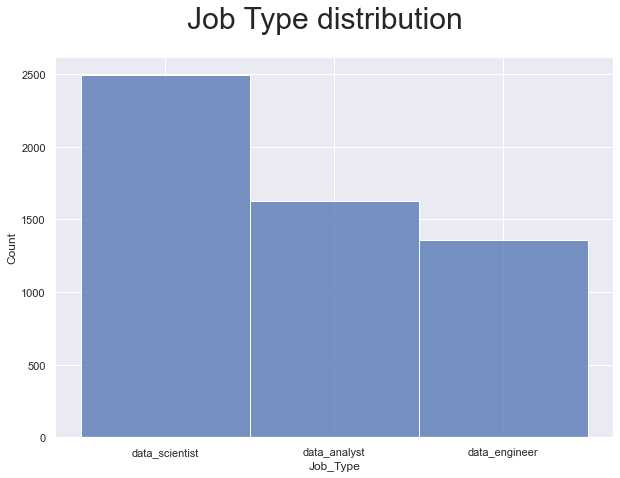

In [30]:
# Creating a histogram to visualize the distribution of the job types in the dataset
histplt, ax = plt.subplots(figsize = (10,7))
ax = sns.histplot(job_df.Job_Type)
plt.suptitle("Job Type distribution", size = 30);

###### Comments:

There are more data scientist jobs in this dataset.

### 2.4 Importing both resume dataset

#### 2.4.1 First resume dataset

In [31]:
# Importing first resume dataset
resume_1 = pd.read_csv("../datasets/resume.csv")

In [32]:
# Subset of how the dataframe looks like
resume_1.head()

Category  \
0  Data Science   
1  Data Science   
2  Data Science   
3  Data Science   
4  Data Science   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [33]:
# applying the function onto the first resume dataset
basic_info(resume_1)

========== Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB
None

=========== Shape ===========
(row, column) = (962, 2)

====== Total Null/Dup =======
Total Null Rows: 0 (0.0%)
Total Duplicate Rows: 958 (99.58%)


###### Comments: 
There are no null values but it seems like there is a 99.58% of duplicated values. Let's probe into the duplicated entries

In [34]:
# locating the duplicates in the dataset for comparison
resume_1.loc[(resume_1.duplicated(keep=False))].head(10)

Category  \
0  Data Science   
1  Data Science   
2  Data Science   
3  Data Science   
4  Data Science   
5  Data Science   
6  Data Science   
7  Data Science   
8  Data Science   
9  Data Science   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [35]:
# Checking the different Job types in the dataset
resume_1.Category.unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

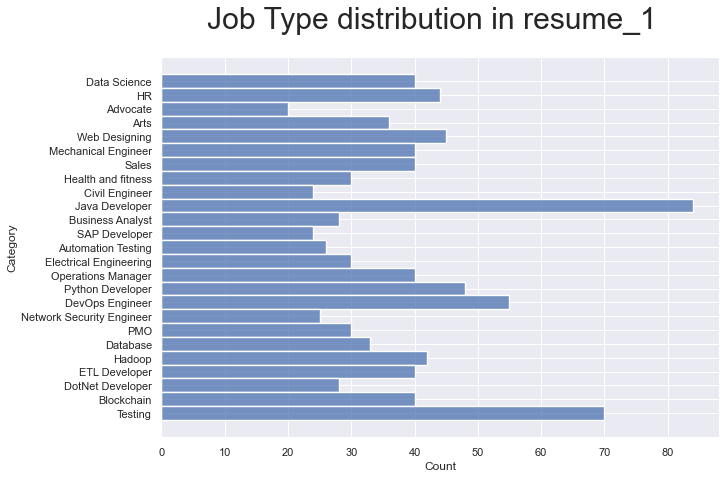

In [36]:
# Creating a histogram to visualize the distribution of the job types in the dataset
histplt, ax = plt.subplots(figsize = (10,7))
ax = sns.histplot(y=resume_1.Category)
plt.suptitle("Job Type distribution in resume_1", size = 30);

###### Comments:

Java Developer resumes stand out with the highest count. On top of that we can see there are alot of other resumes with counts around 40 in the tech industry. 

#### 2.4.2 Second resume dataset

In [37]:
resume_2 = pd.read_csv("../datasets/resume_2.csv")

In [38]:
resume_2.head()

,Role,Input
0,Web Developer,Web Developer Web Developer Web Developer Work Experience Web Developer TOWN RESIDENTIAL New York NY August 2016 to April 2018 o Designed developed and managed firm s external and internal web applications including main website and document library PHP MySql HTML CSS JS Liquidweb o Created software to transfer data to from third party systems through databases APIs Json and xml feeds o Built from the ground up web applications for the company and top performer agents new projects using Python Django Postgresql and Heroku o Improved and troubleshooted web applications internal databases and external feeds o Collaborated with writers and graphic designers to create and update web content and to convert mockups and designs into responsive web applications including online real estate properties listings news articles agent and team pages and market reports documents o Assisted realtors with websites functionality training and listings syndication concern from and to third party sites Database Administrator August 2015 to August 2016 o Created and Improved functionality for the firm s property management system ColdFusion MS SQL HTML JS o Created and maintained automated periodic reports and notifications delivered by email o Managed planning implementation configuration and administration of MS SQL relational database management systems o Monitored and managed database backups logs and restore and or recover data as required Computer Specialist SOUTH BRONX PREPARATORY Bronx NY September 2010 to August 2015 o Installed maintained troubleshoot and repair all electronic devices software and hardware including replacing components to computers servers printers scanners SMART boards iPads and data projectors located in administrative offices classrooms computer lab and laptop carts o Taught pre calculus and calculus class to top 10 honor students for a full school year o Created maintained and managed students ID cards email accounts and files o Created school website using HTML CSS and bootstrap Education B E in Computer Engineering CITY COLLEGE OF THE CITY UNIVERSITY OF NEW YORK June 2017 Skills API C DJANGO FRONT END Git HASKELL JAVASCRIPT BOOTSTRAP WEBPACK JSON VS CODE OBJECTIVE C PHP PYTHON XML MYSQL POSTGRESQL SQL COLDFUSION HTML5 Links http linkedin com in carlos pro http www CarlosGonzalez pro http www github com cagl18 Additional Information SKILLS Front End Back End Tools Others Skills Key Qualities JavaScript ES6 jQuery Python PostgreSQL Sketch Responsive Design self motivated CSS3 SASS HTML5 Django PHP MySQL Linux Command Line API Integration MVC self learner organized XML JSON Bootstrap ColdFusion MS SQL VS code Eclipse Git Git Flow Github team player Gulp Webpack C Objective C Bitbucket Jira Fluent in ish Haskell Java SCRUM Agile written and spoken
1,Web Developer,Web Developer IT Support Web Developer IT Support Web Developer IT Support Dar us Salaam Cultural Center Eagan MN With more than 15 years of experience in the IT field I have worked and managed deploying various IT applications serving more than 100 000 users and stakeholders I am looking forward into joining an organization that will benefit from my technical and leadership skills as well as contribute in bringing innovative ideas to the organization Work Experience Web Developer IT Support Dar us Salaam Cultural Center Burnsville MN March 2018 to Present Maintained and developed responsive website optimized for desktop tablet and mobile view points Helped establish and guided the website s architecture using various Front end web design skills HTML CSS and JavaScript and Back end Php MysQL Designed and implemented new features enhancements and content of existing website and documented technical and functional specifications Ensured IT services are well maintained and functioning Created Databases using Access and Excel to manage facility s day to day operations Supported Network connectivity Software Installations printers and al

In [39]:
# applying the function onto the second resume dataset
basic_info(resume_2)

========== Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Role    2000 non-null   object
 1   Input   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None

=========== Shape ===========
(row, column) = (2000, 2)

====== Total Null/Dup =======
Total Null Rows: 0 (0.0%)
Total Duplicate Rows: 0 (0.0%)


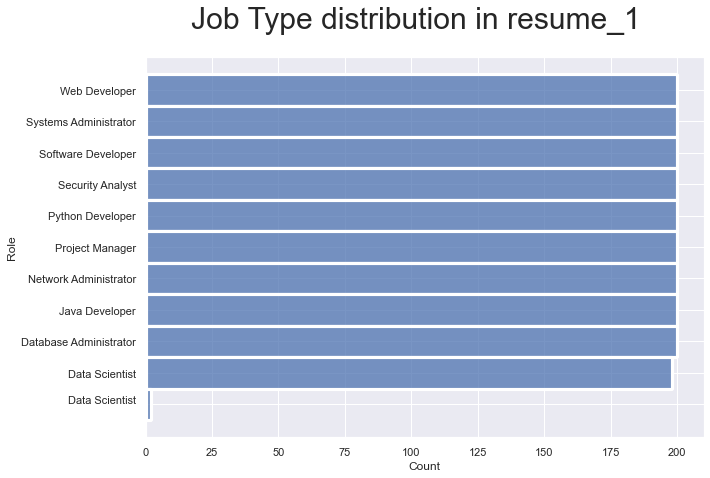

In [40]:
# Creating a histogram to visualize the distribution of the job types in the dataset
histplt, ax = plt.subplots(figsize = (10,7))
ax = sns.histplot(y=resume_2.Role)
plt.suptitle("Job Type distribution in resume_1", size = 30);

###### Comment:
The data is very well distributed howver there seem to be 2 labels for Data Scientist.

In [41]:
# Checking the unique job roles in the dataset
resume_2.Role.unique()

array(['Web Developer', 'Systems Administrator', 'Software Developer',
       'Security Analyst', 'Python Developer', 'Project Manager',
       'Network Administrator', 'Java Developer',
       'Database Administrator', 'Data Scientist', 'Data Scientist\n'],
      dtype=object)

In [42]:
# Rename Data Scientist
resume_2.Role = resume_2.Role.apply(lambda x: 'Data Scientist' if x == 'Data Scientist\n' else x)

In [43]:
# Checking if the change has been implemented
resume_2.Role.unique()

array(['Web Developer', 'Systems Administrator', 'Software Developer',
       'Security Analyst', 'Python Developer', 'Project Manager',
       'Network Administrator', 'Java Developer',
       'Database Administrator', 'Data Scientist'], dtype=object)

#### 2.4.3 Merging both resume dataset

In [44]:
# Resume_2 columns before changing.
resume_2.head(1)

,Role,Input
0,Web Developer,Web Developer Web Developer Web Developer Work Experience Web Developer TOWN RESIDENTIAL New York NY August 2016 to April 2018 o Designed developed and managed firm s external and internal web applications including main website and document library PHP MySql HTML CSS JS Liquidweb o Created software to transfer data to from third party systems through databases APIs Json and xml feeds o Built from the ground up web applications for the company and top performer agents new projects using Python Django Postgresql and Heroku o Improved and troubleshooted web applications internal databases and external feeds o Collaborated with writers and graphic designers to create and update web content and to convert mockups and designs into responsive web applications including online real estate properties listings news articles agent and team pages and market reports documents o Assisted realtors with websites functionality training and listings syndication concern from and to third party sites Database Administrator August 2015 to August 2016 o Created and Improved functionality for the firm s property management system ColdFusion MS SQL HTML JS o Created and maintained automated periodic reports and notifications delivered by email o Managed planning implementation configuration and administration of MS SQL relational database management systems o Monitored and managed database backups logs and restore and or recover data as required Computer Specialist SOUTH BRONX PREPARATORY Bronx NY September 2010 to August 2015 o Installed maintained troubleshoot and repair all electronic devices software and hardware including replacing components to computers servers printers scanners SMART boards iPads and data projectors located in administrative offices classrooms computer lab and laptop carts o Taught pre calculus and calculus class to top 10 honor students for a full school year o Created maintained and managed students ID cards email accounts and files o Created school website using HTML CSS and bootstrap Education B E in Computer Engineering CITY COLLEGE OF THE CITY UNIVERSITY OF NEW YORK June 2017 Skills API C DJANGO FRONT END Git HASKELL JAVASCRIPT BOOTSTRAP WEBPACK JSON VS CODE OBJECTIVE C PHP PYTHON XML MYSQL POSTGRESQL SQL COLDFUSION HTML5 Links http linkedin com in carlos pro http www CarlosGonzalez pro http www github com cagl18 Additional Information SKILLS Front End Back End Tools Others Skills Key Qualities JavaScript ES6 jQuery Python PostgreSQL Sketch Responsive Design self motivated CSS3 SASS HTML5 Django PHP MySQL Linux Command Line API Integration MVC self learner organized XML JSON Bootstrap ColdFusion MS SQL VS code Eclipse Git Git Flow Github team player Gulp Webpack C Objective C Bitbucket Jira Fluent in ish Haskell Java SCRUM Agile written and spoken


In [45]:
# Renaming both dataset to have common columns for merge
resume_2.columns = resume_1.columns

In [46]:
# Resume_2 columns after changing.
resume_2.head(1)

,Category,Resume
0,Web Developer,Web Developer Web Developer Web Developer Work Experience Web Developer TOWN RESIDENTIAL New York NY August 2016 to April 2018 o Designed developed and managed firm s external and internal web applications including main website and document library PHP MySql HTML CSS JS Liquidweb o Created software to transfer data to from third party systems through databases APIs Json and xml feeds o Built from the ground up web applications for the company and top performer agents new projects using Python Django Postgresql and Heroku o Improved and troubleshooted web applications internal databases and external feeds o Collaborated with writers and graphic designers to create and update web content and to convert mockups and designs into responsive web applications including online real estate properties listings news articles agent and team pages and market reports documents o Assisted realtors with websites functionality training and listings syndication concern from and to third party sites Database Administrator August 2015 to August 2016 o Created and Improved functionality for the firm s property management system ColdFusion MS SQL HTML JS o Created and maintained automated periodic reports and notifications delivered by email o Managed planning implementation configuration and administration of MS SQL relational database management systems o Monitored and managed database backups logs and restore and or recover data as required Computer Specialist SOUTH BRONX PREPARATORY Bronx NY September 2010 to August 2015 o Installed maintained troubleshoot and repair all electronic devices software and hardware including replacing components to computers servers printers scanners SMART boards iPads and data projectors located in administrative offices classrooms computer lab and laptop carts o Taught pre calculus and calculus class to top 10 honor students for a full school year o Created maintained and managed students ID cards email accounts and files o Created school website using HTML CSS and bootstrap Education B E in Computer Engineering CITY COLLEGE OF THE CITY UNIVERSITY OF NEW YORK June 2017 Skills API C DJANGO FRONT END Git HASKELL JAVASCRIPT BOOTSTRAP WEBPACK JSON VS CODE OBJECTIVE C PHP PYTHON XML MYSQL POSTGRESQL SQL COLDFUSION HTML5 Links http linkedin com in carlos pro http www CarlosGonzalez pro http www github com cagl18 Additional Information SKILLS Front End Back End Tools Others Skills Key Qualities JavaScript ES6 jQuery Python PostgreSQL Sketch Responsive Design self motivated CSS3 SASS HTML5 Django PHP MySQL Linux Command Line API Integration MVC self learner organized XML JSON Bootstrap ColdFusion MS SQL VS code Eclipse Git Git Flow Github team player Gulp Webpack C Objective C Bitbucket Jira Fluent in ish Haskell Java SCRUM Agile written and spoken


In [47]:
# Merging both dataset together
resume_df = pd.concat([resume_1,resume_2],axis=0).reset_index(drop=True)
resume_df.head()

Category  \
0  Data Science   
1  Data Science   
2  Data Science   
3  Data Science   
4  Data Science   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [48]:
# applying the function onto the combined resume dataset
basic_info(resume_df)

========== Summary ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962 entries, 0 to 2961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2962 non-null   object
 1   Resume    2962 non-null   object
dtypes: object(2)
memory usage: 46.4+ KB
None

=========== Shape ===========
(row, column) = (2962, 2)

====== Total Null/Dup =======
Total Null Rows: 0 (0.0%)
Total Duplicate Rows: 958 (32.34%)


###### Comments:

The duplicated rows were from the first resume and has been addressed.

#### 2.4.4 Cleaning the resume column

In [49]:
def clean_text(text):
    '''
    Input the unclean resume details.
    Output clean details.
    
    '''
    text = text.replace('\n', ' ')                # remove newline
    text = text.replace('/', ' ')                 # remove forward slashes

    text = re.sub(r'[^a-zA-Z ^0-9]', '', text)    # letters only
    text = text.lower()                           # lower case
#     text = re.sub(r'[^0-9]','',text)
#     tet = text.replaceAll("\b\d+\b", "");
    text = re.sub("\s\d+\s", '',text)# remove numbers
    return text




In [50]:
# Applying the function on the resume
resume_df['clean_resume'] = resume_df.Resume.apply(clean_text)

In [51]:
resume_df.head(1)

Category  \
0  Data Science   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [52]:
# Dataset consist of both data science and data scientist.
resume_df.Category.unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing',
       'Web Developer', 'Systems Administrator', 'Software Developer',
       'Security Analyst', 'Project Manager', 'Network Administrator',
       'Database Administrator', 'Data Scientist'], dtype=object)

In [53]:
# Renaming Data Science as Data Scientist
resume_df.Category = resume_df.Category.apply(lambda x: 'Data Scientist' if x == 'Data Science' else x)

In [54]:
# Checking if change has been implemented
resume_df.Category.unique()

array(['Data Scientist', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing',
       'Web Developer', 'Systems Administrator', 'Software Developer',
       'Security Analyst', 'Project Manager', 'Network Administrator',
       'Database Administrator'], dtype=object)

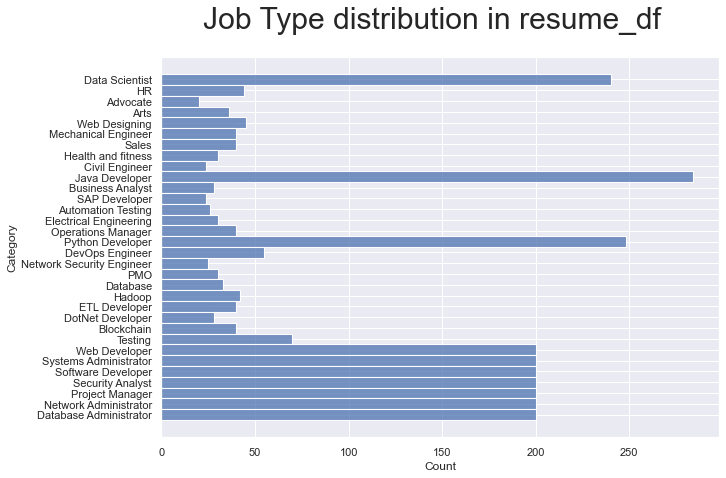

In [55]:
histplt, ax = plt.subplots(figsize = (10,7))
ax = sns.histplot(y=resume_df.Category)
plt.suptitle("Job Type distribution in resume_df", size = 30);

###### Comments: 

After merging both resume dataset and renaming data science to be data scientist, there are still more java and python developers posting.

### 2.5 Exporting the datasets

In [56]:
# # # Renaming Job_title to JobPost_Job_Title for easy identification
# job_df.rename(columns={"Job_Type":"JobPost_Job_Title"},inplace=True)

In [57]:
# # Renaming Category to Resume_Job_Title for easy identification
# resume_df.rename(columns={"Category":"Resume_Job_Title"},inplace=True)

In [58]:
# # Commented the codes to prevent it from executing
# job_df.to_csv("../datasets/clean_job_df.csv",index=False)
# resume_df.to_csv("../datasets/clean_resume_df.csv")

## References

[1] "2021 HR Statistics: Job Search, Hiring, Recruiting & Interviews", Bart Turczynski, April 2021. <br> [Online] Available: https://zety.com/blog/hr-statistics [Accessed: May 11, 2021]

[2] "2017 Recruiter Sentiment Study with insights from Employees and Candidates", The Martec Group, 2017. <br> [Online] Available: https://mrinetwork.com/media/304094/2017hiringsentimentstudy.pdf [Accessed: May 11, 2021]

[3] "Google interview process + interview questions", Kindra Cooper, July 2020. <br> [Online] Available: https://candor.co/articles/interview-prep/google-interview-process-interview-questions [Accessed: May. 9, 2021]